# **発電量のデータを分析する**

### **必要な関数・モジュール**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def get_hours(x):
    '''
    時間帯毎に分類するための関数
    '''
    num = 0
    num += int(x.hour) * 2
    if int(x.minute) == 30:
        num += 1
    return num

In [5]:
def add_times(df):
    '''
    datetimeカラムがあることを前提に年, 月, 時カラムを足す
    '''
    df['hours'] = df['datetime'].map(lambda x: get_hours(x))
    df['month'] = df['datetime'].map(lambda x: x.month)
    df['year'] = df['datetime'].map(lambda x: x.year)
    return df

In [6]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [7]:
def get_input_data(X):
    '''
    全時系列データから00:00 ~ 20:00までのデータごとに分割する
    '''
    input_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(X) // 48
    reshaped_size = X[0:41].shape[0] * X[0:41].shape[1]
    for i in range(total_size+1):
        each_data = X[(i*48):(i*48+41)]
        reshaped = each_data.reshape(reshaped_size)
        input_list.append(list(reshaped))
    input_list = np.array(input_list)
    return input_list

In [8]:
def get_output_data(Y):
    '''
    全時系列データから00:00 ~ 23:30までのデータごとに分割する
    '''
    output_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(Y) // 48
    for i in range(total_size):
        each_data = Y[(i*48):(i*48+48)]
        reshaped = each_data.reshape(48)
        output_list.append(list(reshaped))
    output_list = np.array(output_list)
    return output_list

In [9]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるペアを削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [10]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データを読み込む**

In [29]:
target_place = 2

In [30]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))

In [31]:
# 予測データ
predict_30 = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter = '\t')
predict_30['datetime'] = predict_30['datetime'].map(lambda x : pd.to_datetime(x))
predict_30 = predict_30[['datetime', 'predict_SOLA0'+str(target_place)]]
predict_30.columns = [['datetime', 'prediction']]

In [32]:
# 予測データ
# とりあえず一番valの低い
# targetplace_2_kwh_yokohama_nagoya_osaka_one_layer_5000をつかった
predict_train_30 = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter = '\t')
predict_train_30['datetime'] = predict_train_30['datetime'].map(lambda x : pd.to_datetime(x))
predict_train_30 = predict_train_30[['datetime', 'predict_SOLA0'+str(target_place)]]
predict_train_30.columns = [['datetime', 'prediction']]

In [33]:
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30.columns = [['datetime', 'actual']]

In [34]:
output_30 = add_times(output_30)

In [35]:
# 2016/1/1 ~ 2017/3/31
predict_30 = add_times(predict_30)

In [36]:
# 2012/1/1 ~ 2015/12/31
predict_train_30 = add_times(predict_train_30)

In [37]:
hours_output = output_30.groupby(['hours'], as_index=False).mean()
hours_predict = predict_30.groupby(['hours'], as_index=False).mean()
hours_t_predict = predict_train_30.groupby(['hours'], as_index=False).mean()

### **発電量自体の分析**

In [38]:
ymh_output = output_30.groupby(['year', 'month', 'hours'], as_index=False).mean()

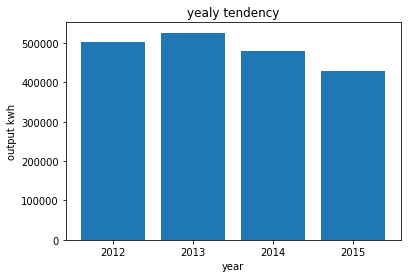

In [39]:
tmp = ymh_output.groupby(['year'], as_index = False).sum()
left = np.array(tmp['year'])
height = np.array(tmp['actual'])
plt.bar(left, height, tick_label = [2012, 2013, 2014, 2015], width=0.8)
plt.title("yealy tendency")
plt.xlabel("year")
plt.ylabel("output kwh")

In [40]:
monthly_output = output_30.groupby(['month'], as_index=False).sum()

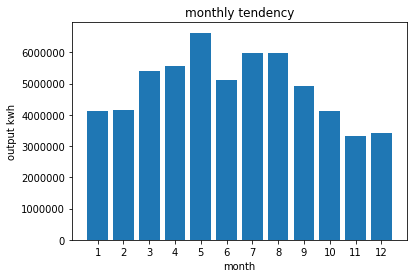

In [41]:
plt.bar(monthly_output['month'], monthly_output['actual'], tick_label=np.arange(12)+1, width = 0.8)
plt.xlabel("month")
plt.ylabel("output kwh")
plt.title("monthly tendency")

In [42]:
ym_output = output_30.groupby(['year', 'month'], as_index=False).sum()

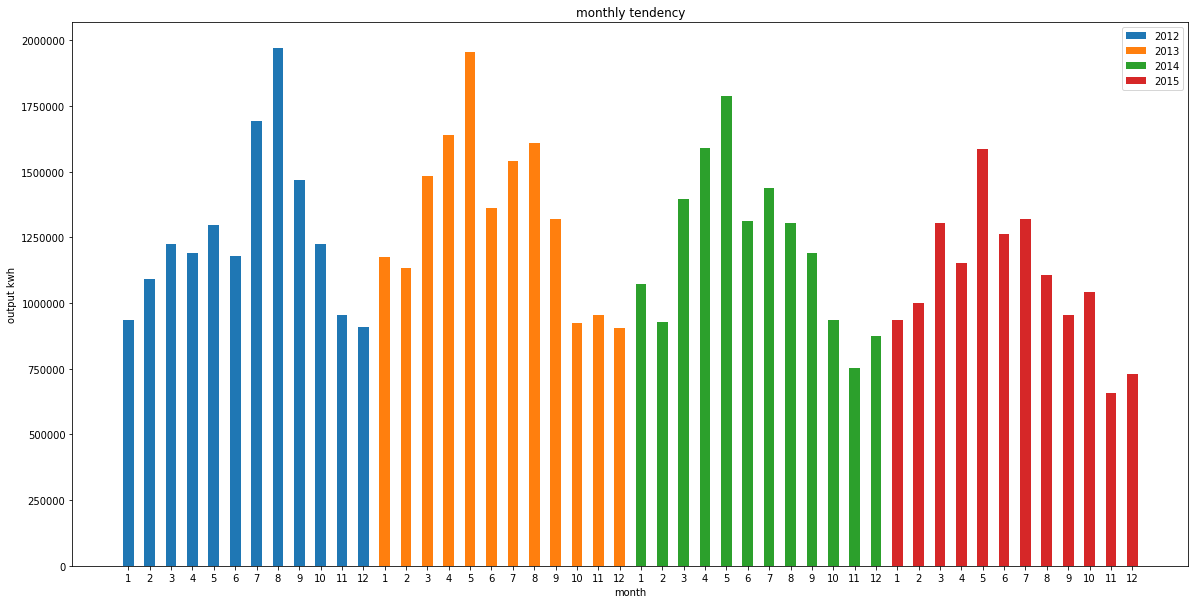

In [43]:
plt.figure(figsize=(20, 10))
month = np.arange(len(ym_output))
plt.bar(month[0:12], ym_output['actual'][0:12], width = 0.5, label="2012")
plt.bar(month[12:24], ym_output['actual'][12:24], width = 0.5, label="2013")
plt.bar(month[24:36], ym_output['actual'][24:36], width = 0.5, label="2014")
plt.bar(month[36:48], ym_output['actual'][36:48], width = 0.5, label="2015")
plt.xticks(np.arange(len(ym_output)), month % 12 + 1)
plt.legend()
plt.xlabel("month")
plt.ylabel("output kwh")
plt.title("monthly tendency")

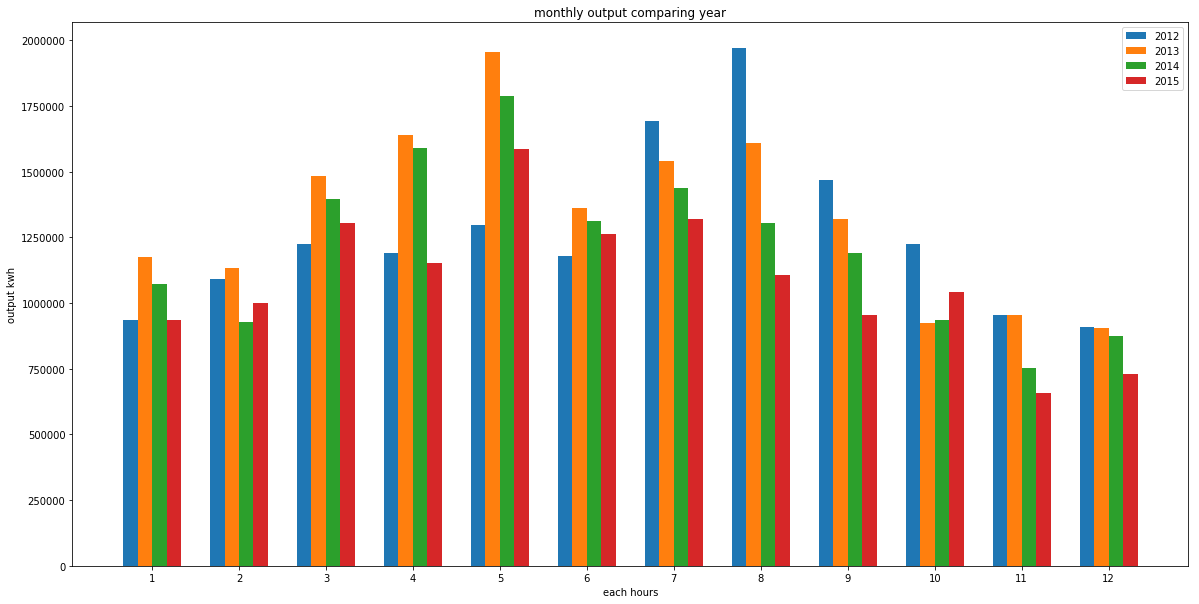

In [44]:
month = np.array(ym_output['month'][0:12])
left_1 = month*3 - 0.75
height_1 = np.array(ym_output['actual'][0:12])
left_2 = month*3 - 0.25
height_2 = np.array(ym_output['actual'][12:24])
left_3 = month*3 + 0.25
height_3 = np.array(ym_output['actual'][24:36])
left_4 = month*3 + 0.75
height_4 = np.array(ym_output['actual'][36:48])
plt.figure(figsize=(20, 10))
plt.bar(left_1, height_1, width=0.5, label = "2012")
plt.bar(left_2, height_2, width=0.5, label = "2013")
plt.bar(left_3, height_3, width=0.5, label = "2014")
plt.bar(left_4, height_4, width=0.5, label = "2015")
plt.title("monthly output comparing year")
plt.legend()
plt.xticks(month * 3, month)
plt.xlabel("each hours")
plt.ylabel("output kwh")

### **浮島発電所と挙動が違いすぎない？？2015年減りすぎでは？**

### **分析スタート**

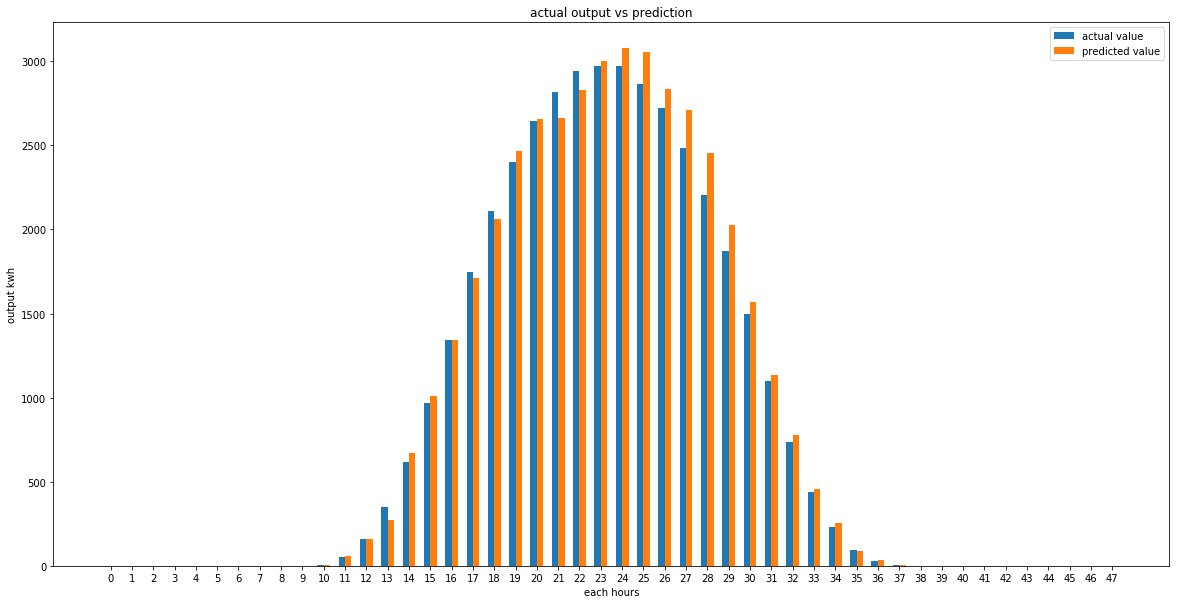

In [45]:
left_1 = np.array(hours_output['hours']) - 0.15
height_1 = np.array(hours_output['actual'])
left_2 = np.array(hours_t_predict['hours']) + 0.15
height_2 = np.array(hours_t_predict['prediction'])
plt.figure(figsize=(20, 10))
plt.bar(left_1, height_1, width=0.3, label = "actual value", align="center")
plt.bar(left_2, height_2, width=0.3, label = "predicted value", align="center")
plt.title("actual output vs prediction")
plt.legend()
plt.xticks(left_1+0.15, np.array(hours_output['hours']))
plt.xlabel("each hours")
plt.ylabel("output kwh")

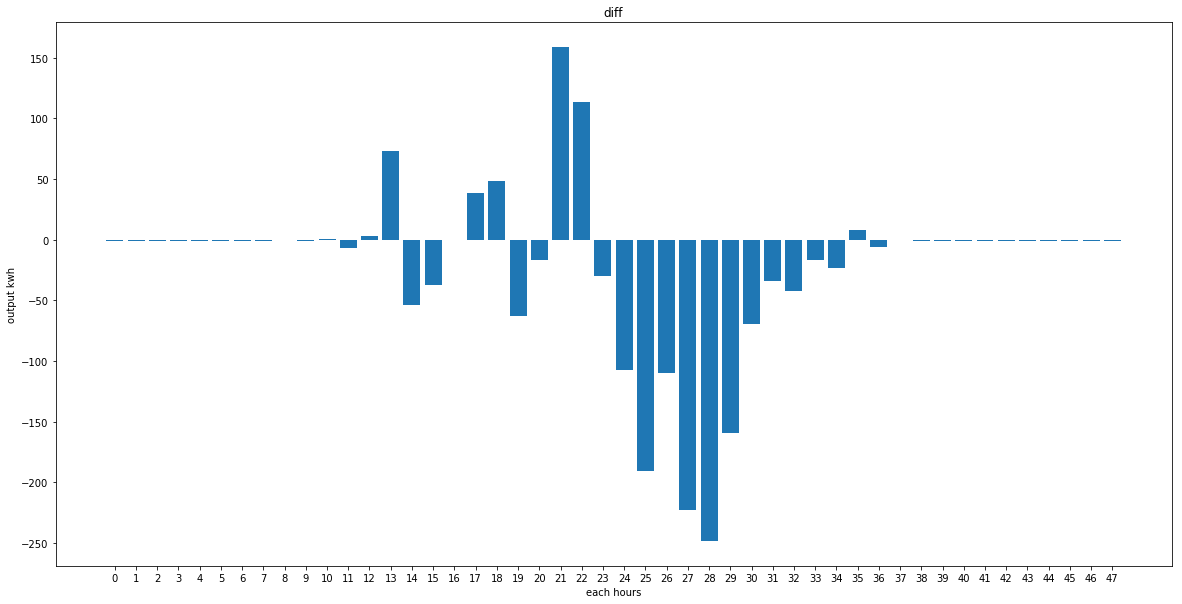

In [48]:
left = np.array(hours_output['hours'])
height = np.array(hours_output['actual']) - np.array(hours_t_predict['prediction'])
plt.figure(figsize=(20, 10))
plt.bar(left, height, width=0.8, align="center")
plt.title("diff")
plt.xticks(left, np.array(hours_output['hours']))
plt.xlabel("each hours")
plt.ylabel("output kwh")

** ピークの位置がずれている、午後の時間を過大に評価している(2015年の影響？？)** 

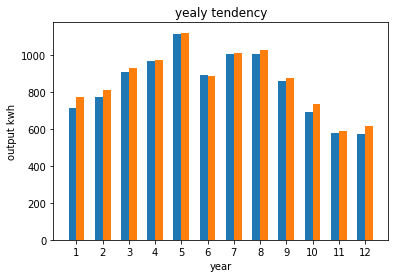

In [49]:
m_output_30 = output_30.groupby(['month'], as_index=False).mean()
m_t_predict_30 = predict_train_30.groupby(['month'], as_index=False).mean()
height_1 = np.array(m_output_30['actual'])
height_2 = np.array(m_t_predict_30['prediction'])
left_1 = np.arange(12) - 0.15
left_2 = np.arange(12) + 0.15
plt.bar(left_1, height_1, width=0.3)
plt.bar(left_2, height_2, width=0.3)
plt.xticks(left_1+0.15, np.arange(12)+1)
plt.title("yealy tendency")
plt.xlabel("year")
plt.ylabel("output kwh")

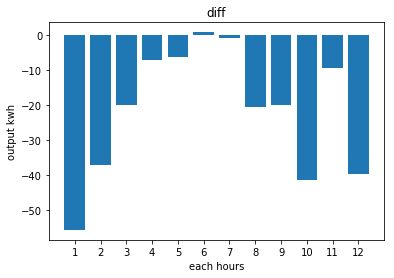

In [50]:
left = np.arange(12)
height = np.array(m_output_30['actual']) - np.array(m_t_predict_30['prediction'])
plt.bar(left, height, width=0.8, align="center")
plt.title("diff")
plt.xticks(left, left+1)
plt.xlabel("each hours")
plt.ylabel("output kwh")

### **どの月が苦手とかはないっぽい(強いて言えば冬か？)**

In [62]:
ym_output = output_30.groupby(['year', 'month'], as_index=False).sum()
ym_t_predict = predict_train_30.groupby(['year', 'month'], as_index=False).sum()

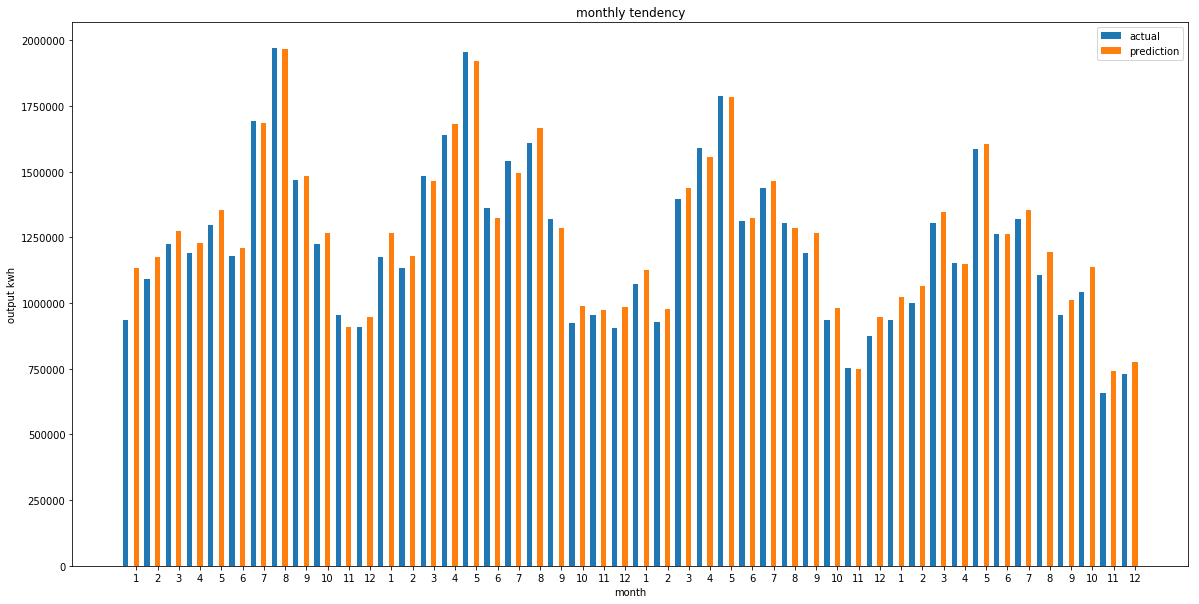

In [63]:
plt.figure(figsize=(20, 10))
month = np.arange(len(ym_output))
plt.bar(month-0.5, ym_output['actual'], width = 0.25, label="actual")
plt.bar(month, ym_t_predict['prediction'], width = 0.25, label="prediction")
plt.xticks(np.arange(len(ym_output)), month % 12 + 1)
plt.legend()
plt.xlabel("month")
plt.ylabel("output kwh")
plt.title("monthly tendency")

In [64]:
# 年と時間帯を合わせた分析もしとこうかな？
yh_output = output_30.groupby(['year', 'hours'], as_index=False).mean()
yh_t_predict = predict_train_30.groupby(['year', 'hours'], as_index=False).mean()

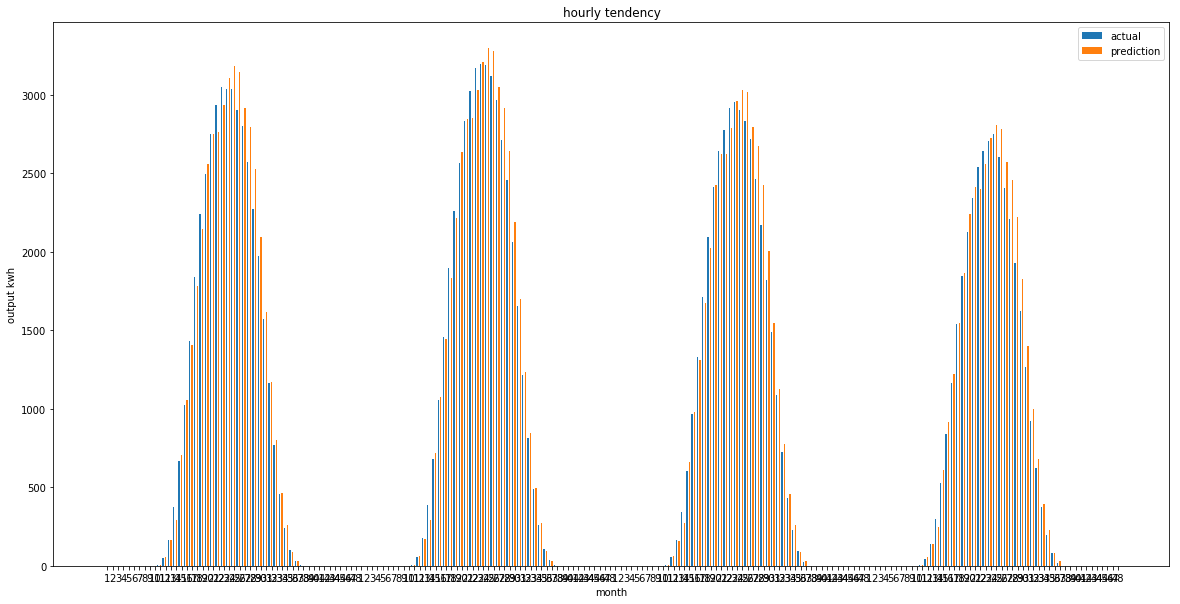

In [68]:
hours = np.arange(192)
plt.figure(figsize=(20,10))
plt.bar(hours-0.5, yh_output['actual'], width = 0.25, label="actual")
plt.bar(hours, yh_t_predict['prediction'], width = 0.25, label="prediction")
plt.xticks(np.arange(len(yh_output)), hours % 48 + 1)
plt.legend()
plt.xlabel("month")
plt.ylabel("output kwh")
plt.title("hourly tendency")

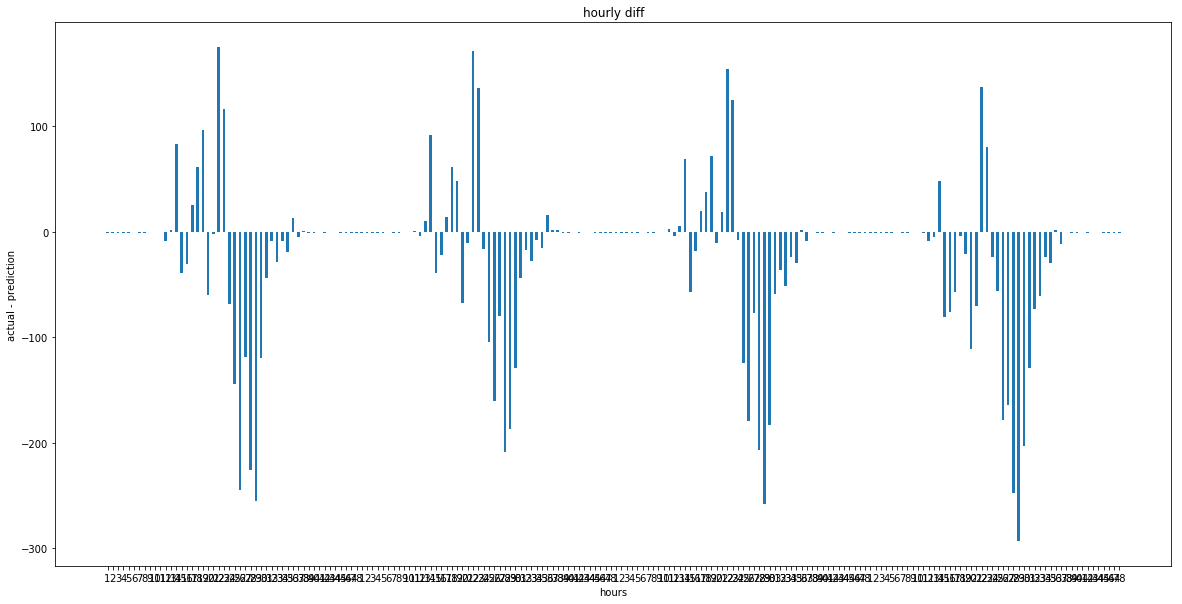

In [71]:
hours = np.arange(192)
plt.figure(figsize=(20,10))
plt.bar(hours, yh_output['actual'] - yh_t_predict['prediction'], width = 0.5)
plt.xticks(np.arange(len(yh_output)), hours % 48 + 1)
plt.xlabel("hours")
plt.ylabel("actual - prediction")
plt.title("hourly diff")

### **どの年も午後の予測が下手だなぁ**